In [ ]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay,
    classification_report, average_precision_score, precision_recall_curve
)
from joblib import dump

# Plot styling
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (9, 5)

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Load data
DATA_PATH = Path("/Users/dhwanil/Desktop/ONGOING PROJECTS/customer churn/data/churn.csv")
assert DATA_PATH.exists(), f"File not found: {DATA_PATH}"

df_raw = pd.read_csv(DATA_PATH)  # read once
df = df_raw.copy()               # working copy

print(df.shape)
df.head()

(7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


In [13]:
# Inspect schema & missingness
display(df.info())
display(df.describe(include="all").T.head(20))
df.isna().sum().sort_values(ascending=False).head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,7043,7043,7590-VHVEG,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,7043,2,Male,3555,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SeniorCitizen,7043.0,NaN,NaN,NaN,0.162147,0.368612,0.0,0.0,0.0,0.0,1.0
Partner,7043,2,No,3641,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,7043,2,No,4933,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tenure,7043.0,NaN,NaN,NaN,32.371149,24.559481,0.0,9.0,29.0,55.0,72.0
PhoneService,7043,2,Yes,6361,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MultipleLines,7043,3,No,3390,NaN,NaN,NaN,NaN,NaN,NaN,NaN
InternetService,7043,3,Fiber optic,3096,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OnlineSecurity,7043,3,No,3498,NaN,NaN,NaN,NaN,NaN,NaN,NaN


customerID          0
DeviceProtection    0
TotalCharges        0
MonthlyCharges      0
PaymentMethod       0
PaperlessBilling    0
Contract            0
StreamingMovies     0
StreamingTV         0
TechSupport         0
dtype: int64

In [ ]:
# Strip spaces in object columns and standardize text
for col in df.select_dtypes(include="object").columns:
    df[col] = df[col].astype(str).str.strip()

# Convert TotalCharges to numeric (known issue in Telco dataset)
if "TotalCharges" in df.columns:
    df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# Map Churn Yes/No -> 1/0
if "Churn" in df.columns:
    df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0}).astype("Int64")

# Convert SeniorCitizen to a categorical-like string for clarity
if "SeniorCitizen" in df.columns and pd.api.types.is_numeric_dtype(df["SeniorCitizen"]):
    df["SeniorCitizen"] = df["SeniorCitizen"].map({1: "Yes", 0: "No"}).astype("string")

# Handle missing values lightly (keep for imputer in pipeline, but drop rows with missing target)
df = df[~df["Churn"].isna()].copy()

missing_summary = df.isna().sum().sort_values(ascending=False)
missing_summary.head(10)


TotalCharges        11
customerID           0
DeviceProtection     0
MonthlyCharges       0
PaymentMethod        0
PaperlessBilling     0
Contract             0
StreamingMovies      0
StreamingTV          0
TechSupport          0
dtype: int64

In [15]:
# Basic target distribution
churn_rate = df["Churn"].mean()
print(f"Dataset shape: {df.shape}, Churn rate: {churn_rate:.3f}")

# Create tenure bins for visualization
if "tenure" in df.columns:
    df["tenure_bin"] = pd.cut(
        df["tenure"],
        bins=[-1, 6, 12, 24, 36, 48, 60, df["tenure"].max()],
        labels=["0-6", "7-12", "13-24", "25-36", "37-48", "49-60", "60+"]
    )
df.head(3)


Dataset shape: (7043, 21), Churn rate: 0.265


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_bin
0,7590-VHVEG,Female,No,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,0-6
1,5575-GNVDE,Male,No,No,No,34,Yes,No,DSL,Yes,...,No,No,No,One year,No,Mailed check,56.95,1889.50,0,25-36
2,3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,0-6


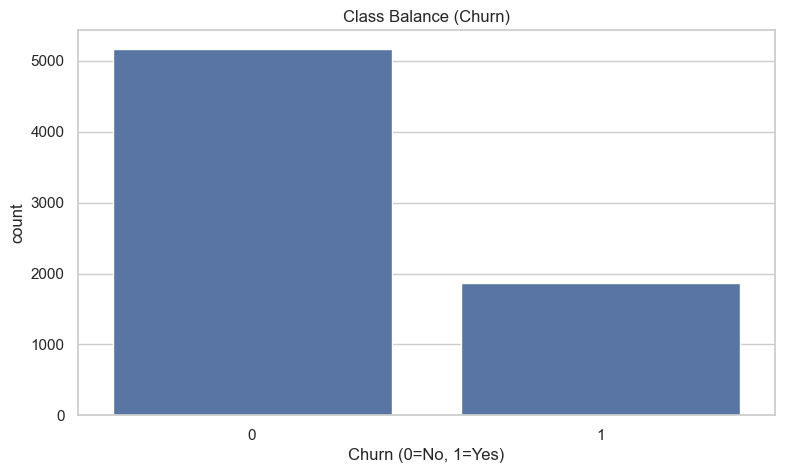

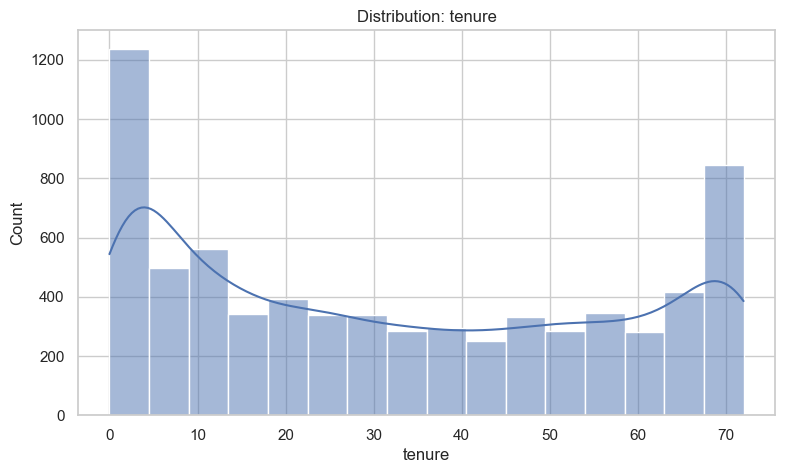

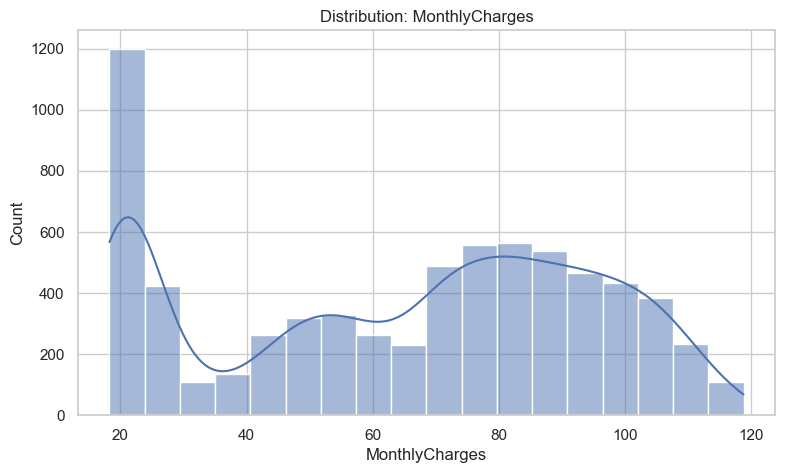

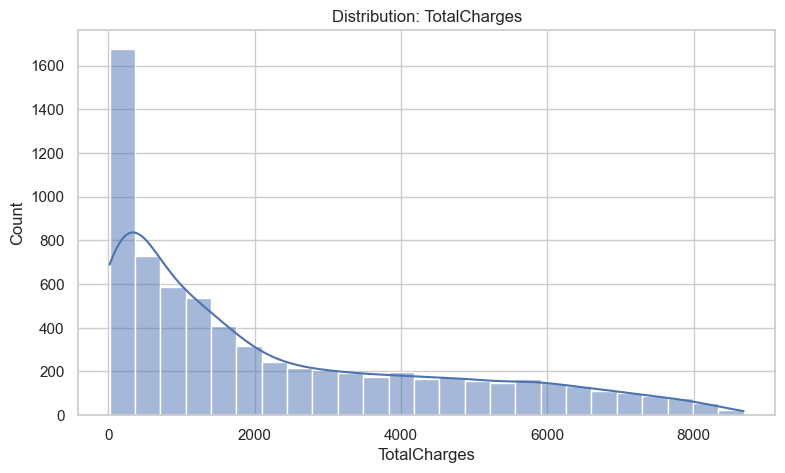

In [16]:
fig, ax = plt.subplots()
sns.countplot(data=df, x="Churn", ax=ax)
ax.set_title("Class Balance (Churn)")
ax.set_xlabel("Churn (0=No, 1=Yes)")
plt.show()

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c != "Churn"]

for col in numeric_cols[:6]:  # show a few key ones
    fig, ax = plt.subplots()
    sns.histplot(df[col].dropna(), kde=True, ax=ax)
    ax.set_title(f"Distribution: {col}")
    plt.show()


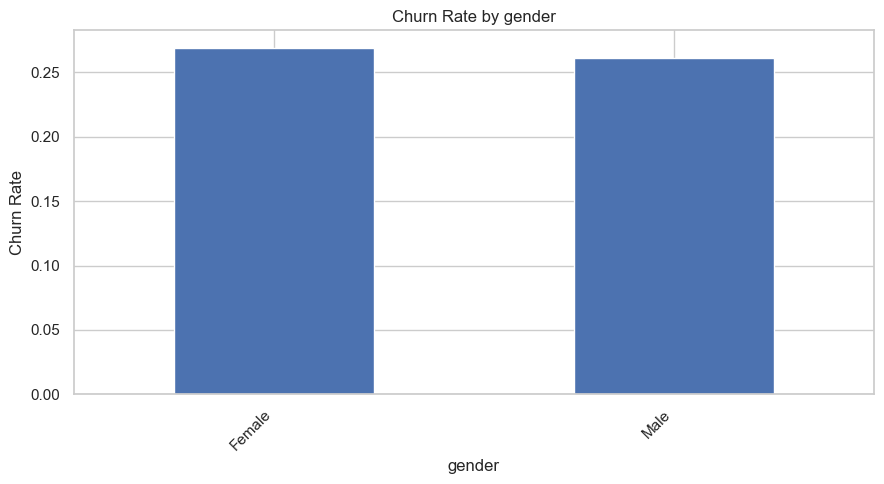

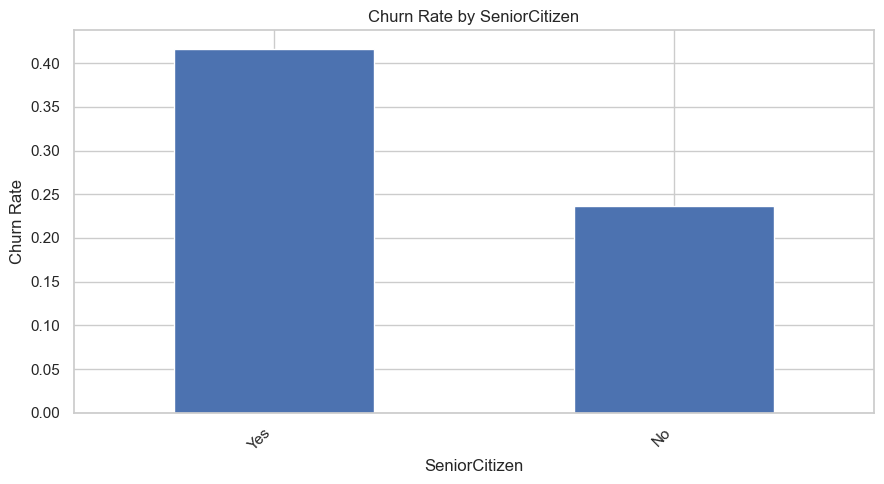

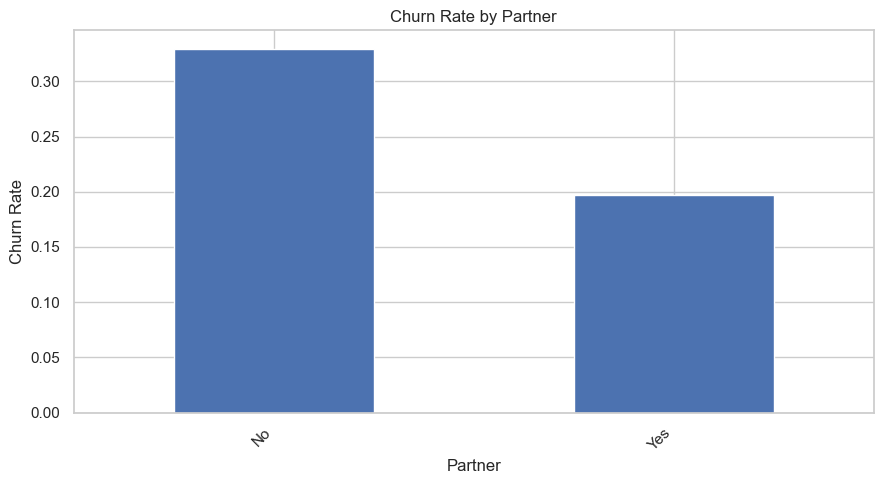

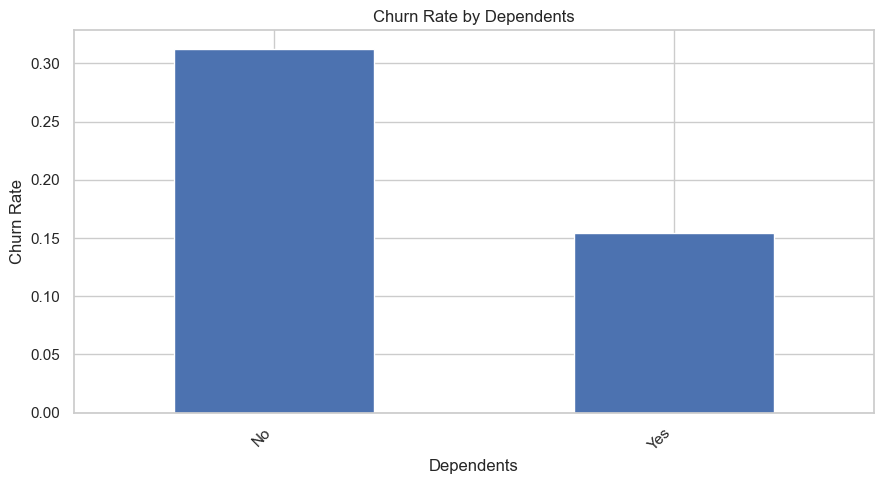

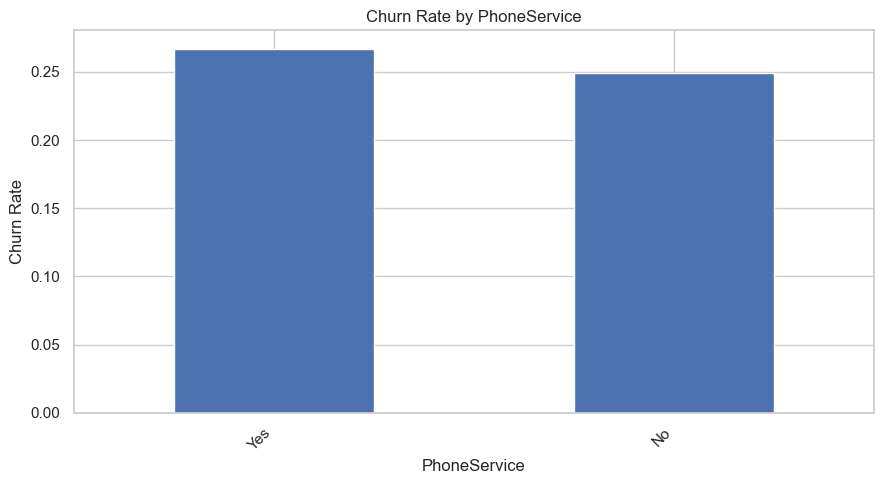

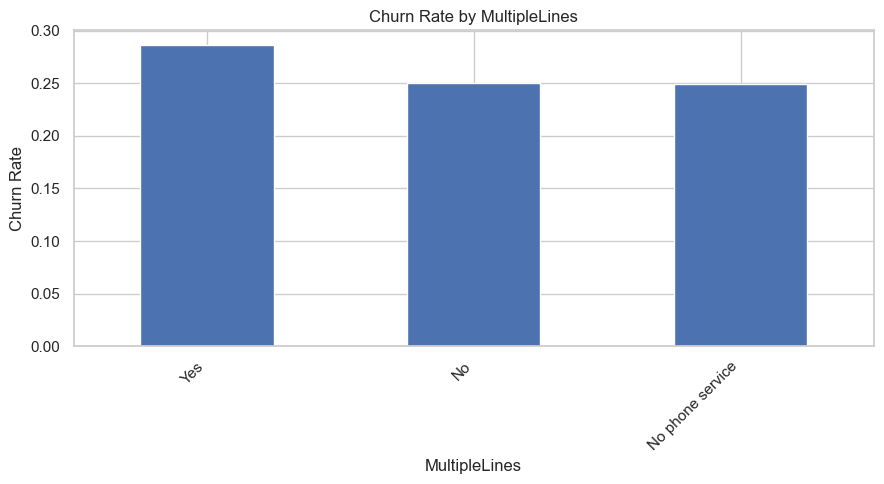

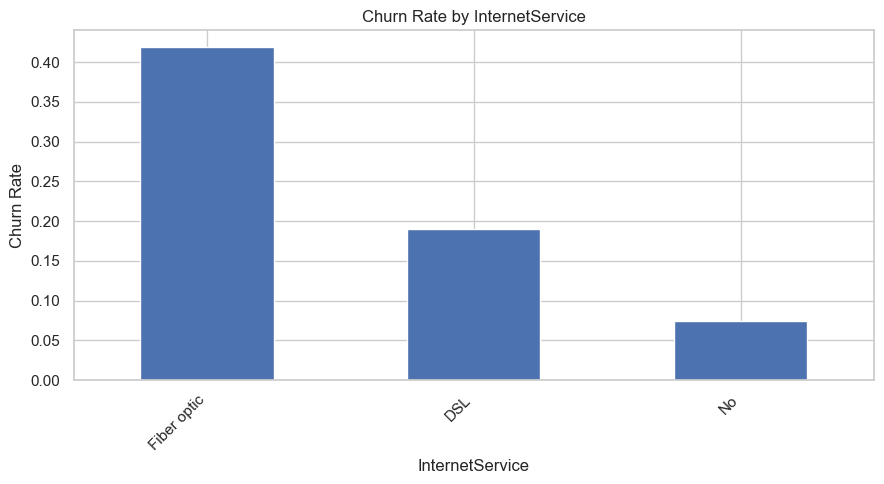

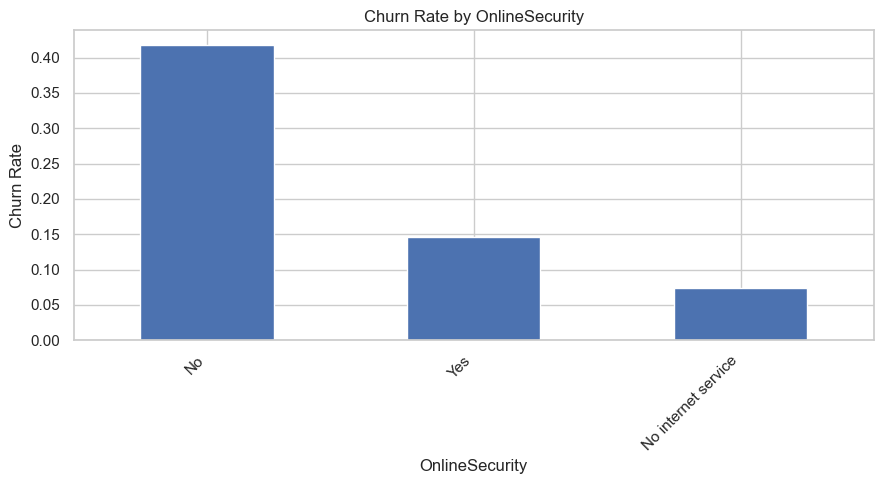

In [17]:
cat_cols = df.select_dtypes(include=["object", "string", "category"]).columns.tolist()
cat_cols = [c for c in cat_cols if c not in ("customerID", "Churn")]  # exclude id/target

def bar_churn_rate(col):
    tmp = df.groupby(col)["Churn"].mean().sort_values(ascending=False)
    ax = tmp.plot(kind="bar")
    ax.set_ylabel("Churn Rate")
    ax.set_title(f"Churn Rate by {col}")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

for col in cat_cols[:8]:  # preview top categorical drivers
    bar_churn_rate(col)


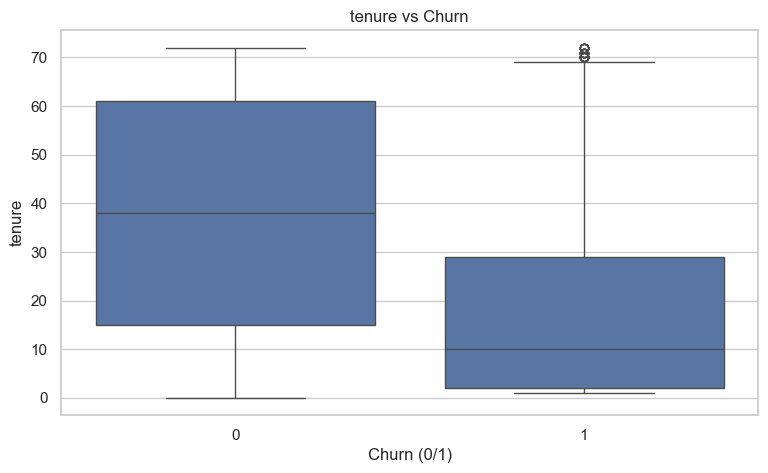

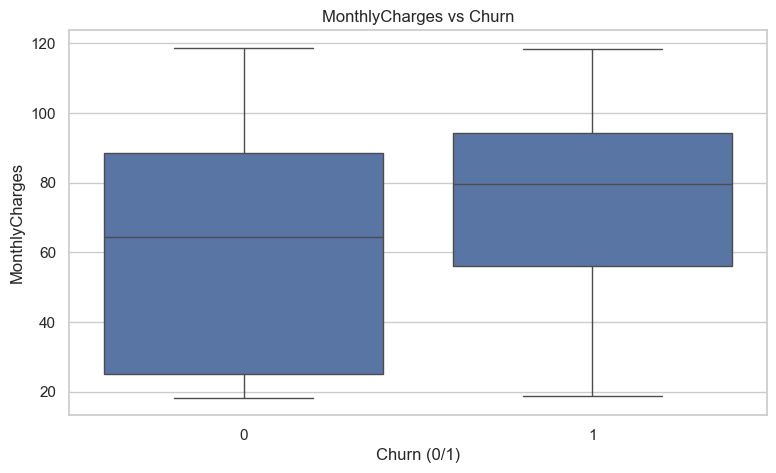

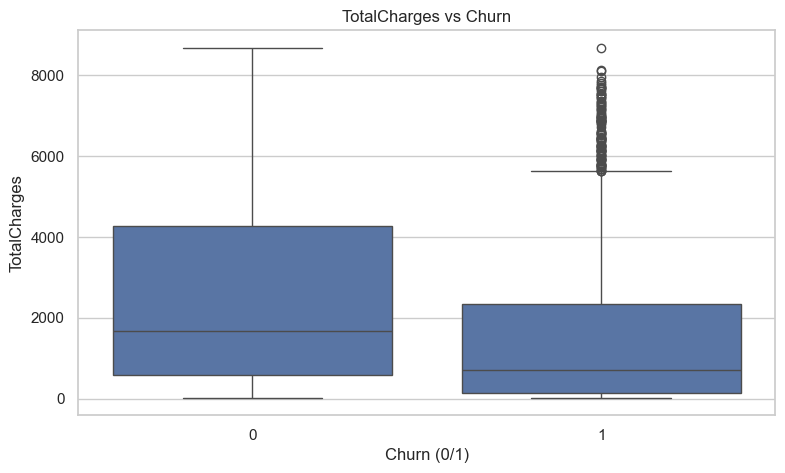

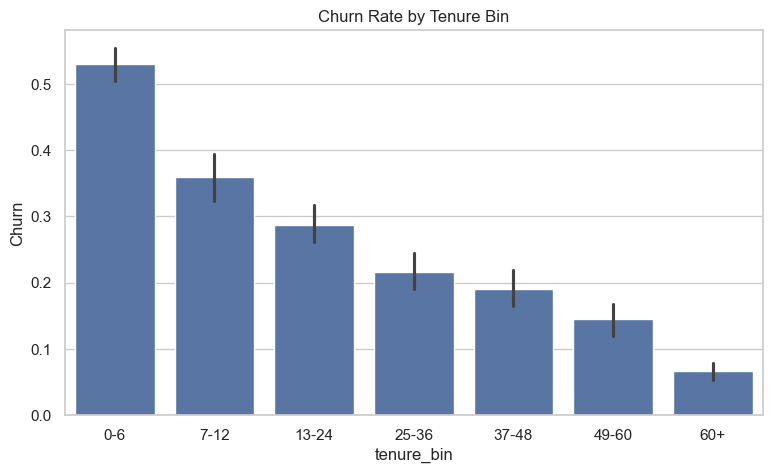

In [18]:
for col in numeric_cols[:6]:
    fig, ax = plt.subplots()
    sns.boxplot(data=df, x="Churn", y=col, ax=ax)
    ax.set_title(f"{col} vs Churn")
    ax.set_xlabel("Churn (0/1)")
    plt.show()

if "tenure_bin" in df.columns:
    fig, ax = plt.subplots()
    sns.barplot(data=df, x="tenure_bin", y="Churn", estimator=np.mean, ax=ax)
    ax.set_title("Churn Rate by Tenure Bin")
    plt.xticks(rotation=0)
    plt.show()
